# Is it a banger?

In [1]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
np.random.seed(1337)
import pandas as pd
%matplotlib inline

## The Dataset

In [2]:
df = pd.read_pickle("../data/processed_dataset.pkl")

In [3]:
bangerz = df.loc[df['label'] == "banger"]
clangerz = df.loc[df['label'] == "not_a_banger"]
num_bangerz = bangerz.index.size
num_clangerz = clangerz.index.size
print( "Dataset has %g \"banger\"s and %g \"not_a_banger\"s" % (num_bangerz, num_clangerz) )

Dataset has 422 "banger"s and 453 "not_a_banger"s


In [4]:
def plot_waveforms(df, idx):
    audio = df.iloc[idx].audio
    log_specgram = df.iloc[idx].log_specgram
    filename = df.iloc[idx].name
    label = df.iloc[idx].label
    # audio is np.array holding sample values, log_specgram is 2-dim np.array
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(audio, sr=22050)
    plt.subplot(1, 2, 2)
    librosa.display.specshow(log_specgram, x_axis='time',y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.suptitle(filename + ", label = \"" + label + "\".")


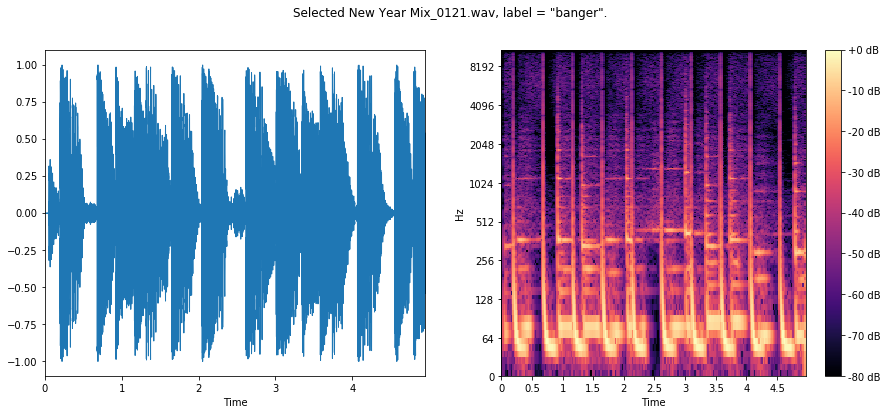

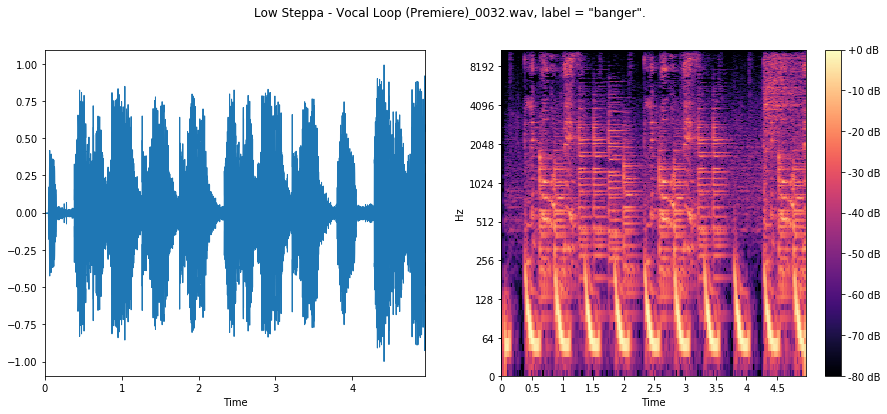

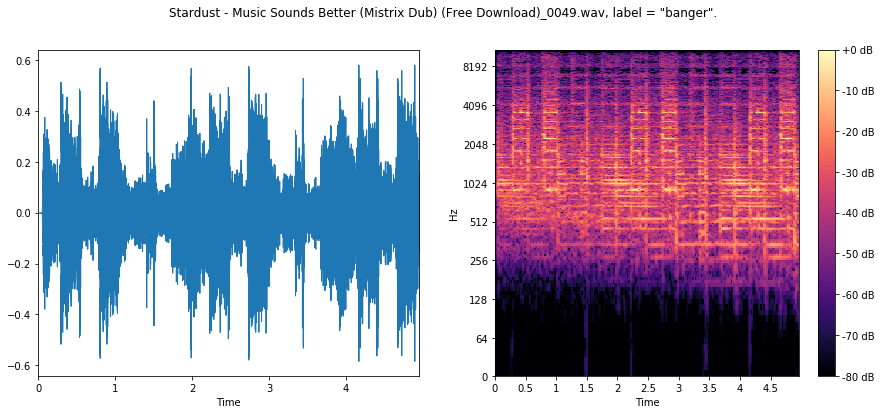

In [68]:
[plot_waveforms(bangerz, i) for i in [0, 1, 2]];

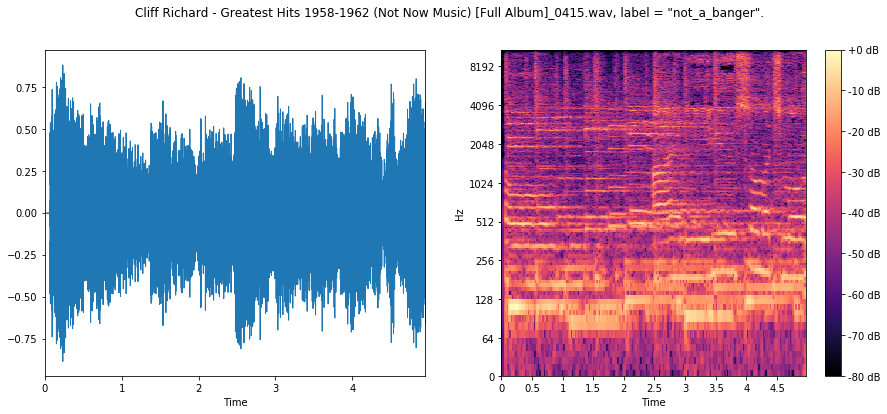

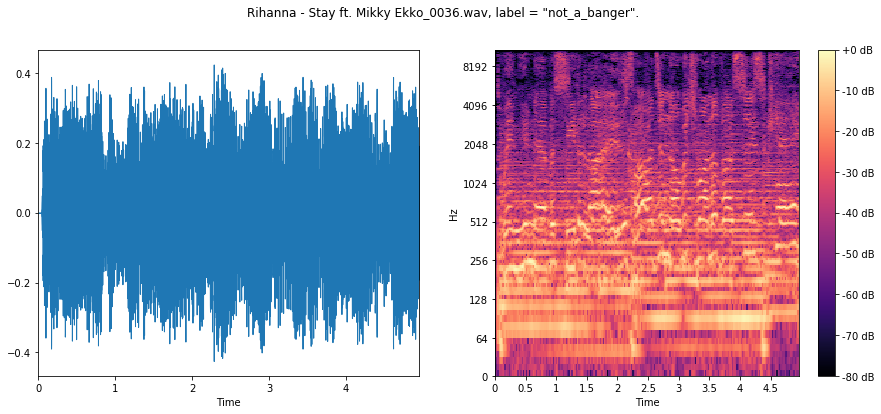

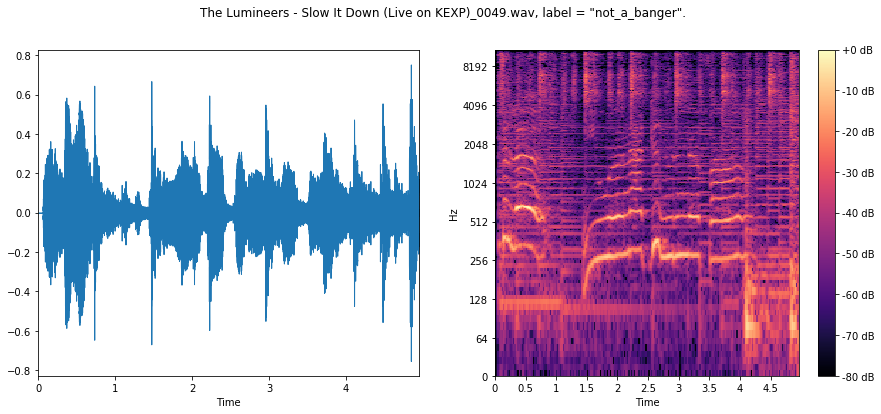

In [67]:
[plot_waveforms(clangerz, i) for i in [0, 1, 2]];

## Establish baseline

In [6]:
naive_accuracy = (max(num_bangerz, num_clangerz) / (float)(df.index.size))
print ("This is the accuracy if we always guess max{#banger, #not_a_banger}: %.3f" % naive_accuracy)

This is the accuracy if we always guess max{#banger, #not_a_banger}: 0.518


## Form the training and testing data sets¶

In [7]:
train_frac = 0.8

def split_train_test(df, train_frac=0.8):
    include = np.random.rand(*df.index.shape)
    is_train = include < train_frac
    train_data = df[is_train]
    test_data = df[~is_train]
    return train_data, test_data
                
train_data, test_data = split_train_test(df, train_frac)

In [61]:
print( "Training data has %g clips, test data has %g clips." % (train_data.index.size, test_data.index.size))

Training data has 688 clips, test data has 187 clips.


In [10]:
import tensorflow as tf
tf.set_random_seed(1234)

In [39]:
# convolution params

log_specgram_shape = df.iloc[0]["log_specgram"].shape
CONV_STRIDE_LENGTH = 1
CONV_WINDOW_LENGTH = 5
MAX_POOL_STRIDE_LENGTH = 2

# features
CONV_1_NUM_FEATURES = 32
CONV_2_NUM_FEATURES = 16
DENSE_NUM_FEATURES = 256

# training
NUM_LABELS = df.label.unique().size
BATCH_SIZE = 50
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
LOG_TRAIN_STEPS = 1

In [40]:
# This node is where we feed a batch of the training data and labels at each training step
x = tf.placeholder(tf.float32,shape=(None, *log_specgram_shape, 1))
y_ = tf.placeholder(tf.float32, shape=(None, len(df.label.unique())))

In [41]:
# Weight initialisation functions
 
# small noise for symmetry breaking and non-zero gradients
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# ReLU neurons - initialise with small positive bias to stop 'dead' neurons
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [42]:
def conv2d(x, W):  
    return tf.nn.conv2d(x, W, strides=[1, CONV_STRIDE_LENGTH, CONV_STRIDE_LENGTH, 1], padding='SAME')

# ksize is filter size
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1],
                        strides=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1], padding='SAME')



### First Convolutional Layer
We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of `[5, 5, 1, 32]`. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [43]:
W_conv1 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, 1, CONV_1_NUM_FEATURES])
b_conv1 = bias_variable([CONV_1_NUM_FEATURES])

In [44]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 16 features for each 5x5 patch.

In [46]:
W_conv2 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, CONV_1_NUM_FEATURES, CONV_2_NUM_FEATURES])
b_conv2 = bias_variable([CONV_2_NUM_FEATURES])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 2x2 maxpool gives image dimensions np.ceil(np.array(log_specgram_shape)/2).astype(int)

### Densely Connected Layer

Now that the image size has been reduced to `$SHAPE`, we add a fully-connected layer with 256 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [48]:
def scale_shape_maxpool2x2(shape_tuple):
    return np.ceil(np.array(shape_tuple)/2).astype(int)

log_specgram_shape_reduced = scale_shape_maxpool2x2(scale_shape_maxpool2x2(log_specgram_shape))

W_fc1 = weight_variable([np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES, DENSE_NUM_FEATURES])
b_fc1 = bias_variable([DENSE_NUM_FEATURES])

h_pool2_flat = tf.reshape(h_pool2, [-1, np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a `placeholder` for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's `tf.nn.dropout` op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [50]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

Finally, we add a layer, just like for the one layer softmax regression.

In [51]:
W_fc2 = weight_variable([DENSE_NUM_FEATURES, NUM_LABELS])
b_fc2 = bias_variable([NUM_LABELS])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

### Batching function

In [52]:
def return_batch(df, batch_size=10):
    batch_df = df.sample(batch_size)
    x = np.vstack(batch_df["log_specgram"]).reshape(batch_df.index.size, *log_specgram_shape, 1).astype(np.float32)
    y = np.vstack(batch_df["label_one_hot"]).astype(np.float32)
    return x, y

### Time logging

In [53]:
import time

def estimate_time_remaining(time_in, current_step, steps_gap, total_steps):
    current_time = time.time() - time_in
    time_per_step = current_time / steps_gap
    time_remaining = (total_steps - current_step) * time_per_step
    m, s = divmod(time_remaining, 60)
    h, m = divmod(m, 60)
    print("Approximately %d hours, %02d minutes, %02d seconds remaining." % (h, m, s))
    

### Train and Evaluate the Model


In [54]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

with sess.as_default():
    current_time = time.time()
    for i in range(NUM_EPOCHS):
        batch = return_batch(train_data, BATCH_SIZE)
        
        # logging
        if i % LOG_TRAIN_STEPS == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('Epoch %d, training accuracy %.3f' % (i, train_accuracy))
            estimate_time_remaining(current_time, i, LOG_TRAIN_STEPS, NUM_EPOCHS)
            current_time = time.time()

        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})


step 0, training accuracy 0.440
Approximately 5 hours, 44 minutes, 37 seconds remaining.
step 1, training accuracy 0.540
Approximately 13 hours, 19 minutes, 45 seconds remaining.
step 2, training accuracy 0.500
Approximately 13 hours, 22 minutes, 32 seconds remaining.
step 3, training accuracy 0.560
Approximately 12 hours, 21 minutes, 02 seconds remaining.
step 4, training accuracy 0.580
Approximately 12 hours, 13 minutes, 26 seconds remaining.
step 5, training accuracy 0.560
Approximately 12 hours, 09 minutes, 58 seconds remaining.
step 6, training accuracy 0.500
Approximately 12 hours, 40 minutes, 11 seconds remaining.
step 7, training accuracy 0.500
Approximately 12 hours, 28 minutes, 34 seconds remaining.
step 8, training accuracy 0.540
Approximately 12 hours, 56 minutes, 10 seconds remaining.
step 9, training accuracy 0.600
Approximately 15 hours, 25 minutes, 33 seconds remaining.
step 10, training accuracy 0.780
Approximately 14 hours, 07 minutes, 34 seconds remaining.
step 11, t

step 91, training accuracy 0.960
Approximately 12 hours, 06 minutes, 49 seconds remaining.
step 92, training accuracy 0.840
Approximately 11 hours, 42 minutes, 26 seconds remaining.
step 93, training accuracy 0.980
Approximately 14 hours, 02 minutes, 09 seconds remaining.
step 94, training accuracy 0.880
Approximately 14 hours, 28 minutes, 08 seconds remaining.
step 95, training accuracy 0.860
Approximately 11 hours, 47 minutes, 34 seconds remaining.
step 96, training accuracy 0.840
Approximately 11 hours, 51 minutes, 26 seconds remaining.
step 97, training accuracy 0.920
Approximately 11 hours, 47 minutes, 12 seconds remaining.
step 98, training accuracy 0.900
Approximately 13 hours, 53 minutes, 52 seconds remaining.
step 99, training accuracy 0.940
Approximately 14 hours, 26 minutes, 30 seconds remaining.
step 100, training accuracy 0.880
Approximately 13 hours, 36 minutes, 01 seconds remaining.
step 101, training accuracy 0.920
Approximately 17 hours, 41 minutes, 52 seconds remainin

step 181, training accuracy 0.840
Approximately 10 hours, 49 minutes, 13 seconds remaining.
step 182, training accuracy 0.840
Approximately 10 hours, 15 minutes, 20 seconds remaining.
step 183, training accuracy 0.820
Approximately 10 hours, 25 minutes, 38 seconds remaining.
step 184, training accuracy 0.900
Approximately 13 hours, 06 minutes, 45 seconds remaining.
step 185, training accuracy 0.940
Approximately 15 hours, 37 minutes, 47 seconds remaining.
step 186, training accuracy 0.880
Approximately 14 hours, 40 minutes, 26 seconds remaining.
step 187, training accuracy 0.900
Approximately 11 hours, 24 minutes, 09 seconds remaining.
step 188, training accuracy 0.900
Approximately 12 hours, 51 minutes, 18 seconds remaining.
step 189, training accuracy 0.920
Approximately 12 hours, 30 minutes, 38 seconds remaining.
step 190, training accuracy 0.880
Approximately 12 hours, 51 minutes, 14 seconds remaining.
step 191, training accuracy 0.880
Approximately 13 hours, 02 minutes, 27 seconds

step 271, training accuracy 0.820
Approximately 11 hours, 24 minutes, 54 seconds remaining.
step 272, training accuracy 0.840
Approximately 12 hours, 15 minutes, 47 seconds remaining.
step 273, training accuracy 0.920
Approximately 11 hours, 45 minutes, 13 seconds remaining.
step 274, training accuracy 0.960
Approximately 11 hours, 24 minutes, 07 seconds remaining.
step 275, training accuracy 0.940
Approximately 11 hours, 38 minutes, 43 seconds remaining.
step 276, training accuracy 0.840
Approximately 11 hours, 23 minutes, 40 seconds remaining.
step 277, training accuracy 0.920
Approximately 11 hours, 52 minutes, 37 seconds remaining.
step 278, training accuracy 0.940
Approximately 11 hours, 37 minutes, 46 seconds remaining.
step 279, training accuracy 0.880
Approximately 11 hours, 33 minutes, 54 seconds remaining.
step 280, training accuracy 0.880
Approximately 13 hours, 25 minutes, 52 seconds remaining.
step 281, training accuracy 0.940
Approximately 13 hours, 18 minutes, 24 seconds

step 361, training accuracy 0.980
Approximately 10 hours, 08 minutes, 02 seconds remaining.
step 362, training accuracy 0.880
Approximately 9 hours, 45 minutes, 54 seconds remaining.
step 363, training accuracy 0.920
Approximately 9 hours, 42 minutes, 29 seconds remaining.
step 364, training accuracy 0.860
Approximately 10 hours, 03 minutes, 14 seconds remaining.
step 365, training accuracy 0.960
Approximately 9 hours, 44 minutes, 05 seconds remaining.
step 366, training accuracy 0.940
Approximately 9 hours, 15 minutes, 04 seconds remaining.
step 367, training accuracy 0.880
Approximately 8 hours, 36 minutes, 30 seconds remaining.
step 368, training accuracy 0.920
Approximately 8 hours, 48 minutes, 57 seconds remaining.
step 369, training accuracy 0.860
Approximately 8 hours, 29 minutes, 13 seconds remaining.
step 370, training accuracy 0.880
Approximately 8 hours, 30 minutes, 58 seconds remaining.
step 371, training accuracy 0.940
Approximately 8 hours, 19 minutes, 29 seconds remainin

step 452, training accuracy 0.960
Approximately 7 hours, 32 minutes, 28 seconds remaining.
step 453, training accuracy 0.900
Approximately 7 hours, 14 minutes, 36 seconds remaining.
step 454, training accuracy 0.920
Approximately 7 hours, 16 minutes, 55 seconds remaining.
step 455, training accuracy 0.980
Approximately 7 hours, 13 minutes, 51 seconds remaining.
step 456, training accuracy 0.860
Approximately 7 hours, 01 minutes, 46 seconds remaining.
step 457, training accuracy 1.000
Approximately 7 hours, 18 minutes, 45 seconds remaining.
step 458, training accuracy 0.900
Approximately 8 hours, 38 minutes, 55 seconds remaining.
step 459, training accuracy 0.920
Approximately 7 hours, 29 minutes, 51 seconds remaining.
step 460, training accuracy 0.900
Approximately 7 hours, 03 minutes, 11 seconds remaining.
step 461, training accuracy 0.980
Approximately 6 hours, 59 minutes, 27 seconds remaining.
step 462, training accuracy 0.940
Approximately 7 hours, 14 minutes, 13 seconds remaining.

step 543, training accuracy 0.960
Approximately 5 hours, 40 minutes, 18 seconds remaining.
step 544, training accuracy 0.980
Approximately 5 hours, 41 minutes, 43 seconds remaining.
step 545, training accuracy 0.920
Approximately 5 hours, 40 minutes, 27 seconds remaining.
step 546, training accuracy 0.900
Approximately 5 hours, 38 minutes, 50 seconds remaining.
step 547, training accuracy 0.940
Approximately 5 hours, 44 minutes, 02 seconds remaining.
step 548, training accuracy 0.960
Approximately 5 hours, 35 minutes, 20 seconds remaining.
step 549, training accuracy 0.880
Approximately 5 hours, 38 minutes, 44 seconds remaining.
step 550, training accuracy 0.980
Approximately 5 hours, 28 minutes, 36 seconds remaining.
step 551, training accuracy 0.980
Approximately 5 hours, 33 minutes, 43 seconds remaining.
step 552, training accuracy 0.940
Approximately 5 hours, 31 minutes, 57 seconds remaining.
step 553, training accuracy 0.940
Approximately 5 hours, 31 minutes, 44 seconds remaining.

step 634, training accuracy 1.000
Approximately 4 hours, 35 minutes, 36 seconds remaining.
step 635, training accuracy 0.960
Approximately 4 hours, 32 minutes, 22 seconds remaining.
step 636, training accuracy 0.860
Approximately 4 hours, 31 minutes, 05 seconds remaining.
step 637, training accuracy 0.940
Approximately 4 hours, 34 minutes, 33 seconds remaining.
step 638, training accuracy 0.920
Approximately 4 hours, 38 minutes, 47 seconds remaining.
step 639, training accuracy 0.880
Approximately 4 hours, 27 minutes, 16 seconds remaining.
step 640, training accuracy 1.000
Approximately 4 hours, 26 minutes, 46 seconds remaining.
step 641, training accuracy 0.940
Approximately 4 hours, 35 minutes, 45 seconds remaining.
step 642, training accuracy 0.940
Approximately 4 hours, 25 minutes, 06 seconds remaining.
step 643, training accuracy 0.900
Approximately 4 hours, 26 minutes, 14 seconds remaining.
step 644, training accuracy 0.960
Approximately 4 hours, 21 minutes, 13 seconds remaining.

step 725, training accuracy 1.000
Approximately 3 hours, 29 minutes, 13 seconds remaining.
step 726, training accuracy 0.960
Approximately 3 hours, 24 minutes, 17 seconds remaining.
step 727, training accuracy 0.960
Approximately 3 hours, 25 minutes, 44 seconds remaining.
step 728, training accuracy 1.000
Approximately 3 hours, 33 minutes, 27 seconds remaining.
step 729, training accuracy 0.980
Approximately 3 hours, 21 minutes, 43 seconds remaining.
step 730, training accuracy 0.940
Approximately 3 hours, 25 minutes, 36 seconds remaining.
step 731, training accuracy 0.940
Approximately 3 hours, 21 minutes, 34 seconds remaining.
step 732, training accuracy 0.980
Approximately 3 hours, 17 minutes, 36 seconds remaining.
step 733, training accuracy 0.980
Approximately 3 hours, 27 minutes, 21 seconds remaining.
step 734, training accuracy 0.980
Approximately 3 hours, 51 minutes, 56 seconds remaining.
step 735, training accuracy 0.900
Approximately 3 hours, 45 minutes, 41 seconds remaining.

step 816, training accuracy 0.940
Approximately 2 hours, 17 minutes, 23 seconds remaining.
step 817, training accuracy 1.000
Approximately 2 hours, 18 minutes, 46 seconds remaining.
step 818, training accuracy 1.000
Approximately 2 hours, 14 minutes, 54 seconds remaining.
step 819, training accuracy 0.980
Approximately 2 hours, 17 minutes, 06 seconds remaining.
step 820, training accuracy 0.920
Approximately 2 hours, 15 minutes, 50 seconds remaining.
step 821, training accuracy 0.920
Approximately 2 hours, 12 minutes, 59 seconds remaining.
step 822, training accuracy 0.980
Approximately 2 hours, 17 minutes, 51 seconds remaining.
step 823, training accuracy 0.940
Approximately 2 hours, 18 minutes, 38 seconds remaining.
step 824, training accuracy 0.960
Approximately 2 hours, 13 minutes, 54 seconds remaining.
step 825, training accuracy 0.880
Approximately 2 hours, 10 minutes, 56 seconds remaining.
step 826, training accuracy 0.960
Approximately 2 hours, 12 minutes, 09 seconds remaining.

step 907, training accuracy 0.900
Approximately 1 hours, 08 minutes, 40 seconds remaining.
step 908, training accuracy 0.960
Approximately 1 hours, 12 minutes, 55 seconds remaining.
step 909, training accuracy 0.980
Approximately 1 hours, 09 minutes, 19 seconds remaining.
step 910, training accuracy 0.900
Approximately 1 hours, 08 minutes, 01 seconds remaining.
step 911, training accuracy 0.980
Approximately 1 hours, 06 minutes, 25 seconds remaining.
step 912, training accuracy 0.960
Approximately 1 hours, 07 minutes, 52 seconds remaining.
step 913, training accuracy 0.940
Approximately 1 hours, 06 minutes, 18 seconds remaining.
step 914, training accuracy 0.960
Approximately 1 hours, 04 minutes, 43 seconds remaining.
step 915, training accuracy 0.880
Approximately 1 hours, 03 minutes, 31 seconds remaining.
step 916, training accuracy 0.900
Approximately 1 hours, 04 minutes, 30 seconds remaining.
step 917, training accuracy 0.960
Approximately 1 hours, 03 minutes, 39 seconds remaining.

step 998, training accuracy 0.980
Approximately 0 hours, 01 minutes, 32 seconds remaining.
step 999, training accuracy 0.980
Approximately 0 hours, 00 minutes, 48 seconds remaining.
test accuracy 0.914


ValueError: Parent directory of model.ckpt doesn't exist, can't save.

### Save model and variables

In [59]:
with sess.as_default():
    saver = tf.train.Saver()
    save_path = saver.save(sess, "../data/model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: ../data/model.ckpt


### Testing

In [69]:
with sess.as_default():
    test_batch = return_batch(test_data, test_data.index.size)
    test_accuracy = accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1], keep_prob: 1.0})
    print("Test accuracy: %.3f" % test_accuracy)

Test accuracy: 0.914
